# Introduction
This notebook serves as a go-along solution for the assignment. Decisions, explanations and thought process are provided before main code blocks and are meant to accommodate the code and comments. The main aspect of this solution is to develop a POC. Therefore suboptimal decisions are periodically made for the sake of expediency and alternatives or improvements are suggested later for a more complete solution.

For the REST API code, plese refer to the python file api.py and for instructions regarding it on the README.txt file

Starting off with package imports, followed by declaration of different helper functions used later in the process.

Globals used are also declared at this point

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from impyute.imputation.cs import mice
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, make_scorer
from pathlib import Path

In [2]:
SEED = 21011993
RESULTS_DIR = './results'
FRAUDS_PATH = './data/fraud_cases.csv'
TRAINING_PATH = './data/FRISS_ClaimHistory_training.csv'
TESTING_PATH = './data/FRISS_ClaimHistory_test.csv'

First part of helper functions has to do with data manipulation/preparation. The second part concerns exploration, visualizations and generally extraction of insights from the different processes.

In [3]:
def __check_directories() -> None:
    """
    Helper function to create a results directory.
    """
    if not Path(RESULTS_DIR).is_dir():
        print (f'[>] Creating results directory: {RESULTS_DIR}')
        Path(RESULTS_DIR).mkdir(parents=True)
    else:
        print (f'[>] Results directory already exists: {RESULTS_DIR}')
    

def __read_data(data_path: str, verbose=False) -> pd.DataFrame:
    """
    Helper function to read data (.csv format) from given directory.

    :param data_path: path to .csv file
    :return: DataFrame of .csv contents
    """
    df = pd.read_csv(Path(data_path), keep_default_na=True)
    print(f'[>] Read {data_path}:')
    print(f' - Shape: {df.shape}')
    if verbose:
        print(f' - Contents: {df.head(5)}')
    return df


def __extract_plain_id(sys_claimid: str) -> str:
    """
    Helper function to extract the plain claim id from the 'sys_claimid' column of the train/test data.

    :param sys_claimid: original id
    :return: plain id
    """
    return sys_claimid.split('-')[1]


def __organize_dataset(data: pd.DataFrame, labels) -> pd.DataFrame:
    """
    Helper function to combine data and labels in the same dataframe. Common index on the 'ClaimID' column used to
    seamlessly combine the two. A new dataframe is created with the features plus a 'fraud' column for the label.
    Duplicate claim ids are also checked and removed.

    :param data: dataframe with the features
    :param labels: dataframe with the frauds
    :return: dataframe of features with new column for their labels
    """
    # apply common index
    data.set_index('ClaimID', inplace=True)
    # duplicate train claim_ids: 603112190, 491813645
    claim_id_val_counts = data.index.value_counts()
    duplicate_ids = [cid for cid, val in claim_id_val_counts.items() if val > 1]
    # manual check: completely different cases -> not fraudulent -> for now, drop all (4)
    data.drop(duplicate_ids, inplace=True)
    # form a labels dataframe to combine easily with the training dataframe
    classes = [(cid, 0) if cid not in labels['ClaimID'].tolist() else (cid, 1) for cid in data.index]
    classes_df = pd.DataFrame(classes, columns=['ClaimID', 'fraud']).set_index('ClaimID')
    # combine training data and labels
    combined_df = pd.concat([data, classes_df], axis=1)

    return combined_df


def __feature_selection(data: pd.DataFrame) -> pd.DataFrame:
    """
    Helper function to remove redundant features from the dataset.

    :param data: dataframe with the features
    :return: dataframe of features without the redundant features
    """
    # dropping one-valued features
    columns_to_drop = ['sys_sector', 'sys_label', 'sys_process', 'sys_product', 'sys_dataspecification_version', 'sys_currency_code']
    # drop names -> DB-based logic/alerts are better in using such specific info
    columns_to_drop.append('ph_firstname')
    columns_to_drop.append('ph_name')
    # drop the more complex id - redundant
    columns_to_drop.append('sys_claimid')
    print(f'[>] Dropping the following columns for lack of infromative value: {columns_to_drop}')
    print('[>] Dropping initial id column, only need one identifier to trace instances')

    return data.drop(columns_to_drop, axis=1)


def __handle_missing_values(data: pd.DataFrame, inference: bool=False) -> pd.DataFrame:
    """
    Helper function to handle missing values on the different features of the dataset. Different approaches 
    are adopted in each case (removal, encoding and imputation).

    :param data: dataframe with the features
    :return: dataframe of features without the redundant features
    """
    # claim_causetype: 2 instances and showed no particularities -> drop
    data.dropna(axis=0, subset=['claim_causetype'], inplace=True)

    # ph_gender: 798 instances and showed no particularities -> 1. drop 2. encode as <no_gender>
    data['ph_gender'].fillna('NG', inplace=True)

    # policy_insured_amount: 30817 instances and showed no particularities -> 1. impute 2. business details (nan=0Euro?)
    cols_to_impute_with = ['claim_amount_claimed_total', 'object_year_construction', 'policy_insured_amount']
    if inference:  # use saved imputer for inference
        with open('knn_imputer_pkl', 'rb') as f:
            knn_imp = pickle.load(f)
    else:
        knn_imp = KNNImputer(n_neighbors=2, weights='distance', add_indicator=True)
    imputed_values = knn_imp.fit_transform(data[cols_to_impute_with])
    data['policy_insured_amount'] = imputed_values[:, 2]

    # drop any rows with negative amounts -> check for negatives meaning
    data = data[data['policy_insured_amount'] >= 0]
    
    # saving imputer for use during inference!
    with open('knn_imputer_pkl', 'wb') as f:
        pickle.dump(knn_imp, f)
    return data


def __prepare_dataset(data: pd.DataFrame) -> pd.DataFrame:
    """
    Function responsible for data preparation before predictive model training. This includes minor preprocessing or
    preparation, transformations and encoding.

    :param data: dataframe with the features
    :return: dataframe with the features prepared to be used by predictive model
    """
    x = pd.DataFrame()
    # deskewing, no zeros on feature on training set, otherwise sqrt could be used or add a minuscule value to zeros
    x['policy_insured_amount'] = np.log(data['policy_insured_amount'])
    x['claim_reported_days'] = np.sqrt(data['claim_reported_days'])
    # from bimodal to normal distribution
    qt_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=SEED)
    x['claim_amount_claimed_total'] = qt_trans.fit_transform(
        data['claim_amount_claimed_total'].to_numpy().reshape(-1, 1)
    )
    x['object_age'] = np.sqrt(data['object_age'])
    # scale data
    scaler = StandardScaler()
    x[['policy_insured_amount', 'claim_amount_claimed_total', 'claim_reported_days', 'object_age']] = \
        scaler.fit_transform(
            x[['policy_insured_amount', 'claim_amount_claimed_total', 'claim_reported_days', 'object_age']]
        )

    categorical = ['claim_causetype', 'claim_location_urban_area', 'object_make', 'ph_gender', 'policy_fleet_flag',
                   'policy_profitability']

    ohe = OneHotEncoder(sparse=False)
    ohe_categorical = ohe.fit_transform(data[categorical])
    for ohe_cat in ohe.categories_[:-1]:
        for col_name, col_values in zip(ohe_cat, ohe_categorical.T):
            x[col_name] = col_values

    # saving transformers/encoders for use during inference!
    with open('qt_trans_pkl', 'wb') as f:
        pickle.dump(qt_trans, f)
    with open('scaler_pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('ohe_pkl', 'wb') as f:
        pickle.dump(ohe, f)
    return x

def __inference_prepare_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Function responsible for data preparation before inference. Saved preprocessing functions are utilized.
    
    :param data: dataframe with the features
    :return: dataframe with the features prepared to be used by predictive model
    """
    with open('qt_trans_pkl', 'rb') as f:
        qt_trans = pickle.load(f)
    with open('scaler_pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('ohe_pkl', 'rb') as f:
        ohe = pickle.load(f)

    x = pd.DataFrame()
    # continuous data
    data['claim_reported_days'] = (
        pd.to_datetime(data['claim_date_reported'], format='%Y%m%d') -
        pd.to_datetime(data['claim_date_occurred'], format='%Y%m%d')
    ).dt.days
    x['policy_insured_amount'] = np.log(data['policy_insured_amount'])
    x['claim_reported_days'] = np.sqrt(data['claim_reported_days'])
    x['claim_amount_claimed_total'] = qt_trans.transform(data['claim_amount_claimed_total'].to_numpy().reshape(-1, 1))
    x['object_age'] = datetime.now().year - data['object_year_construction']
    x[['policy_insured_amount', 'claim_amount_claimed_total', 'claim_reported_days', 'object_age']] = \
        scaler.fit_transform(
            x[['policy_insured_amount', 'claim_amount_claimed_total', 'claim_reported_days', 'object_age']]
        )

    # categorical data
    data.replace({
        'policy_fleet_flag': {0: 'not_policy_fleet', 1: 'policy_fleet'},
        'claim_location_urban_area': {0: 'non_urban', 1: 'urban'}},
        inplace=True)
    categorical = ['claim_causetype', 'claim_location_urban_area', 'object_make', 'ph_gender', 'policy_fleet_flag',
                   'policy_profitability']
    ohe_categorical = ohe.transform(data[categorical])
    for ohe_cat in ohe.categories_[:-1]:
        for col_name, col_values in zip(ohe_cat, ohe_categorical.T):
            x[col_name] = col_values
    return x

In [4]:
def __draw_bar_chart(plot_axis, feature: pd.Series, feature_name: str = '') -> None:
    """
    Helper function to draw a barchart for the given feature. Allows for customization of graph labels and export of
    visualization.

    :param plot_axis: axis of figure to draw a graph on
    :param feature: Series with the feature values
    :param feature_name: name of feature to be used for graph labels and naming, defaults to empty string
    :param export: flag to denote export of the barchart, defaults to False
    """
    plot_axis.bar(x=feature.value_counts().index, height=feature.value_counts().values)
    if len(feature_name) == 0:
        plot_axis.set_title('Barchart of feature')
        plot_axis.set_xlabel('Feature values')
        name = 'feature'
    else:
        plot_axis.set_title(f'Barchart of {feature_name}')
        plot_axis.set_xlabel(f'{feature_name}')
        name = feature_name
    plot_axis.set_ylabel('# of instances')


def __draw_bar_chart_per_class(plot_axis, feature_df: pd.DataFrame, col_name: str, feature_name: str = '') -> None:
    """
    Helper function to draw a barchart for the given feature per class. Allows for customization of graph labels and
    export of visualization.

    :param plot_axis: axis of figure to draw a graph on
    :param feature_df: Dataframe with the feature values and labels
    :param col_name: column name of the feature in provided DataFrame
    :param feature_name: name of feature to be used for graph labels and naming, defaults to empty string
    """
    normal = feature_df[feature_df['fraud'] == 0][col_name].value_counts()
    fraudulent = feature_df[feature_df['fraud'] == 1][col_name].value_counts()

    all_feature_values = list(set(list(normal.index) + list(fraudulent.index)))
    normal_counts = [normal[feature] if feature in normal else 0 for feature in all_feature_values]
    fraudulent_counts = [fraudulent[feature] if feature in fraudulent else 0 for feature in all_feature_values]
    num_features = np.arange(len(all_feature_values))
    w = 0.3
    plot_axis.bar(num_features - w / 2, normal_counts, width=w, color='b', align='center', label='normal')
    plot_axis.bar(num_features + w / 2, fraudulent_counts, width=w, color='g', align='center', label='fraudulent')
    if len(feature_name) == 0:
        plot_axis.set_title('Barchart of feature per class')
        plot_axis.set_xlabel('Feature values')
        name = 'feature'
    else:
        plot_axis.set_title(f'Barchart of {feature_name} per class')
        plot_axis.set_xlabel(f'{feature_name}')
        name = feature_name
    plot_axis.set_xticks(num_features)
    plot_axis.set_xticklabels(all_feature_values)
    plot_axis.legend()


def do_categorical_visualizations(data_df: pd.DataFrame, export: bool = False) -> None:
    """
    Function to generate visualizations/insights on categorical features.

    :param data_df: complete data DataFrame
    :param export: flag to denote export of the graphs, defaults to False
    """
    col_names = ['claim_causetype', 'claim_location_urban_area', 'object_make', 'ph_gender', 'policy_fleet_flag',
                 'policy_profitability']
    feature_names = ['Cause type', 'Claim on urban area', 'Vehicle maker', 'Gender', 'Fleet policy',
                     'Policy profitability']
    graph_counter = 0
    f, ax = plt.subplots(2, 3, figsize=(15, 11))
    for i in range(2):
        for j in range(3):
            __draw_bar_chart(ax[i, j], data_df[col_names[graph_counter]], feature_name=feature_names[graph_counter])
            graph_counter += 1
    plt.suptitle('Features against transaction amount', y=1)
    plt.tight_layout()
    if export:
        plt.savefig(Path(f'./results/cat_barchart.png'), bbox_inches='tight')
    plt.show()
    plt.clf()

    
def do_categorical_visualizations_per_class(data_df: pd.DataFrame, export: bool = False) -> None:
    """
    Function to generate visualizations/insights on categorical features per class.

    :param data_df: complete data DataFrame
    :param export: flag to denote export of the graphs, defaults to False
    """
    col_names = ['claim_causetype', 'claim_location_urban_area', 'object_make', 'ph_gender', 'policy_fleet_flag',
                 'policy_profitability']
    feature_names = ['Cause type', 'Claim on urban area', 'Vehicle maker', 'Gender', 'Fleet policy',
                     'Policy profitability']
    graph_counter = 0
    f, ax = plt.subplots(2, 3, figsize=(15, 11))
    for i in range(2):
        for j in range(3):
            __draw_bar_chart_per_class(ax[i, j], data_df[[col_names[graph_counter],'fraud']], 
                                       col_name=[col_names[graph_counter]],
                                       feature_name=feature_names[graph_counter])
            graph_counter += 1
    plt.suptitle('Features against transaction amount per class', y=1)
    plt.tight_layout()
    if export:
        plt.savefig(Path(f'./results/cat_barchart_per_class.png'), bbox_inches='tight')
    plt.show()
    plt.clf()

    
def __draw_histogram(feature: pd.Series, trans: str = 'square_root', feature_name: str = '', export: bool = False) -> None:
    """
    Helper function to draw a histogram for the given feature. Allows for customization of graph labels and export of
    visualization.

    :param feature: Series with the feature values
    :param feature_name: name of feature to be used for graph labels and naming, defaults to empty string
    :param export: flag to denote export of the histogram, defaults to False
    """
    f, ax = plt.subplots(1, 2, figsize=(11, 5))
    ax[0].hist(x=feature, bins=50)
    if trans == 'log':
        ax[1].hist(x=np.log(feature), bins=50)
    elif trans == 'quartile':
        qt_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=SEED)
        trans_feature = qt_trans.fit_transform(feature.to_numpy().reshape(-1, 1))
        ax[1].hist(x=trans_feature, bins=50)
    else:  # default: square_root
        ax[1].hist(x=np.sqrt(feature), bins=50)
    if len(feature_name) == 0:
        ax[0].set_title('Histogram of feature')
        ax[1].set_title(f'Histogram of {trans}-transformed feature')
        ax[0].set_xlabel(f'Feature values bins')
        ax[1].set_xlabel(f'{trans}-transformed feature values bins')
        name = 'feature'
    else:
        ax[0].set_title(f'Histogram of {feature_name}')
        ax[1].set_title(f'Histogram of {trans}-transformed {feature_name}')
        ax[0].set_xlabel(f'{feature_name} bins')
        ax[1].set_xlabel(f'{trans}-transformed {feature_name} bins')
        name = feature_name
    plt.ylabel('# of instances')
    plt.tight_layout()
    if export:
        plt.savefig(Path(f'./results/{name}_histograms.png'), bbox_inches='tight')
    plt.show()


def do_numerical_visualizations(data_df: pd.DataFrame, export: bool = False) -> None:
    """
    Function to generate visualizations/insights on numerical features.

    :param data_df: complete data DataFrame
    :param export: flag to denote export of the graphs, defaults to False
    """
    __draw_histogram(data_df['policy_insured_amount'], trans='quartile', feature_name='Policy insured amount', export=export)
    __draw_histogram(data_df['claim_amount_claimed_total'], trans='log', feature_name='Total claim amount', export=export)
    __draw_histogram(data_df['claim_reported_days'], trans='square_root', feature_name='Days from occurrence to report', export=export)
    __draw_histogram(data_df['object_age'], trans='square_root', feature_name='Age of vehicle', export=export)
    

## First data inspection
Training data and fraud labels are loaded. Initial inspection of the data revealed that some of the ClaimIDs on the frauds csv have pairs of keys, which needed to be decoupled.

In [5]:
__check_directories()
# read data
frauds_df = __read_data('./data/fraud_cases.csv', verbose=False)
training_df = __read_data('./data/FRISS_ClaimHistory_training.csv', verbose=False)

# unwrap the dash-separated ids from frauds csv
frauds_df['ClaimID'] = frauds_df['ClaimID'].str.split('/')
frauds_df = frauds_df.explode('ClaimID')

[>] Results directory already exists: ./results
[>] Read ./data/fraud_cases.csv:
 - Shape: (618, 2)
[>] Read ./data/FRISS_ClaimHistory_training.csv:
 - Shape: (80000, 20)


## Question 1: How many fraud cases can you find?
This is necessary to properly match fraud labels to instances. To achieve this, a preprocessed version of the IDs of the claims in the features csv will be used, to match the simple ID on the frauds csv. This processed ID will act as index and the combination of the two will be seamless.

In [6]:
# unique fraudulent claims
fraudulent_ids = frauds_df["ClaimID"].tolist()
print(f'[>] Unique fraudulent claims (id-based): {len(set(fraudulent_ids))}')
# get plain id to easily match with ids in frauds_df
training_df['ClaimID'] = training_df['sys_claimid'].apply(__extract_plain_id)
fraudulent_train = training_df[training_df['ClaimID'].isin(fraudulent_ids)]
print(f'[>] Fraudulent transactions in training set: {fraudulent_train.shape[0]}')

[>] Unique fraudulent claims (id-based): 621
[>] Fraudulent transactions in training set: 621


## Question 2: high number of days between the occurrence of the claim and the report date
A "high" number of days between occurrence of an incident and report of a claim can be quite a subjective description. A statistical approach is adopted to define a "high" number. This can be re-adjusted after communication with the client or clarification of the charactirization.

A new column is created, _claim_reported_days_, which will also serve as a feature later in the process. Although its distribution is not exactly normal, its mean and standard deviation is used to threshold the number of days. For that reason differnet thresholds are presented with the corresponding percentage of the instances it cuts off. The most reasonable one is chosen, so that a small but not minuscule number is pointed out as 'high'.

In [7]:
# new column to store the number of days
training_df['claim_reported_days'] = (
        pd.to_datetime(training_df['claim_date_reported'], format='%Y%m%d') -
        pd.to_datetime(training_df['claim_date_occurred'], format='%Y%m%d')
).dt.days
# define "high" number of days based on overall distribution
claim_reported_days_mean = training_df['claim_reported_days'].mean()
claim_reported_days_std = training_df['claim_reported_days'].std()
thresholds = [1, 2, 3, 4, 5]
print('[>] Number of claims per standard deviation threshold')
for thr in thresholds:
    cl = training_df[training_df['claim_reported_days'] > claim_reported_days_mean + thr * claim_reported_days_std].shape[0]
    print(f" -- Over {thr}*std: "
          f"{cl} "
          f"({cl/training_df.shape[0] * 100:.2})%")
print(f'[>] Considering "high" number if over 3 standard deviations.\n'
      f' -- High number of days in training set: {training_df[training_df["claim_reported_days"] > claim_reported_days_mean + 3 * claim_reported_days_std].shape[0]} ({cl/training_df.shape[0] * 100:.2})%')

[>] Number of claims per standard deviation threshold
 -- Over 1*std: 3187 (4.0)%
 -- Over 2*std: 1594 (2.0)%
 -- Over 3*std: 993 (1.2)%
 -- Over 4*std: 651 (0.81)%
 -- Over 5*std: 488 (0.61)%
[>] Considering "high" number if over 3 standard deviations.
 -- High number of days in training set: 993 (0.61)%


## Question 3: Data exploration, cleaning and feature selection & engineering
A first inspection of the data shows a number of features/columns that have only a single value. This makes them poor descriptors of the data for our problem since they provide no additional discrimination value. These features are removed before any more steps are taken. The next features to be removed are the existing, more complex id of the features csv along with the name and surname of the client. None of those three add any information or discrimination value to be included in a predictive model. Names could be used for alerts, but a simple database look-up would suffice for this.



In [8]:
print('[>] Investigating usability of features')
# discovering and dropping non-contributing features/columns
print('[>] Discrete values per dataframe column:')
for col in training_df.columns:
    print(f' -- Unique values for column {col}: {len(set(training_df[col].tolist()))}')
training_df = __feature_selection(training_df)

[>] Investigating usability of features
[>] Discrete values per dataframe column:
 -- Unique values for column sys_sector: 1
 -- Unique values for column sys_label: 1
 -- Unique values for column sys_process: 1
 -- Unique values for column sys_product: 1
 -- Unique values for column sys_dataspecification_version: 1
 -- Unique values for column sys_claimid: 79998
 -- Unique values for column sys_currency_code: 1
 -- Unique values for column claim_amount_claimed_total: 8797
 -- Unique values for column claim_causetype: 6
 -- Unique values for column claim_date_occurred: 2049
 -- Unique values for column claim_date_reported: 2280
 -- Unique values for column claim_location_urban_area: 2
 -- Unique values for column object_make: 7
 -- Unique values for column object_year_construction: 49
 -- Unique values for column ph_firstname: 11486
 -- Unique values for column ph_gender: 4
 -- Unique values for column ph_name: 18237
 -- Unique values for column policy_fleet_flag: 2
 -- Unique values fo

For exploration and visualization, the features are first combined with the labels. On organizing the data it is observed that two different instances have the same ID. Lacking more information at this stage (and since they do not belong to the already heavily outniumbered fraud class) they are removed. Another approach that allows for both to be included would by to simple tweek the ids and thus keep both instances. This can be decided on a later consultation, repeating IDs might not be a simple mistake but a repeating pattern.

Following up is NaN detection and handling. For features with very few missing value instances, the instances are removed (_claim_causetype_, with only 2 instances with missing value). _Gender_ has considerably more (798). Although they do not take a significant percentage of the full dataset, they should not be discarded so easily. The occassion of missing gender is encoded explicitly and utilized on the predictive model. 

Finally _policy_insured_amount_ has a substantial amound of missing values (30817 instances) making dropping the instances not viable. Therefore imputation should be used, to avoid misisng over a third of the data. The imputation technique used here is KNN imputation, to utilize similarity in substituting the missing values. Processing time is a concern for this choice, as KNN is an processing-intensive method. Nevertheless, this number of missing values is something that needs to be discussed further with the client (is it an expected occurrence? does our solution adhere to their process? etc).

In [9]:
# combine training data and labels
combined_df = __organize_dataset(training_df, frauds_df)

In [10]:
# nan statistics: how many NaN are present per feature -> act upon them
print('[>] Nan values per column: ')
print(combined_df.isna().sum())
combined_df = __handle_missing_values(combined_df)

[>] Nan values per column: 
claim_amount_claimed_total        0
claim_causetype                   2
claim_date_occurred               0
claim_date_reported               0
claim_location_urban_area         0
object_make                       0
object_year_construction          0
ph_gender                       798
policy_fleet_flag                 0
policy_insured_amount         30817
policy_profitability              0
claim_reported_days               0
fraud                             0
dtype: int64


## Visualization
Bellow are the visualizations of each feature. They provide us with some insight on the data patterns, both per feature value but also per class. It is also helpful in determining the neccessary transformations in the case of our continuous values.

All in all we observe that all values are present and are so in both classes. Interstingly enough _Gender_ presents the two expected values (male, female), the encoded absence of gender (NG) but also a separate value (L). Discussion with the client might be needed on it, to clarify its nature. For now it is treated as yet another normal value of the feature.

On the case of continuous values, we see that the distributions are not normal, therefore specific transformations are needed. For _policy_insured_amount_ this distribution is after value imputation and it follows still a similar, bit more smoothened bimodal distribution. For this reason we apply Quantile transformation. _claim_reported_days_ will go through square root transform and _claim_amount_claimed_total_ through log transform to normalize their distribution. This was decieded because of zero values in the former and no zero values in the latter. The transformation of _claim_reported_days_ is not as normal-like as intended after these initial transformations, which we should note as we move forward with training and testing a predictive model. There is also possible outlier values on _claim_amount_claimed_total_ and _claim_reported_days_, which should also be noted.

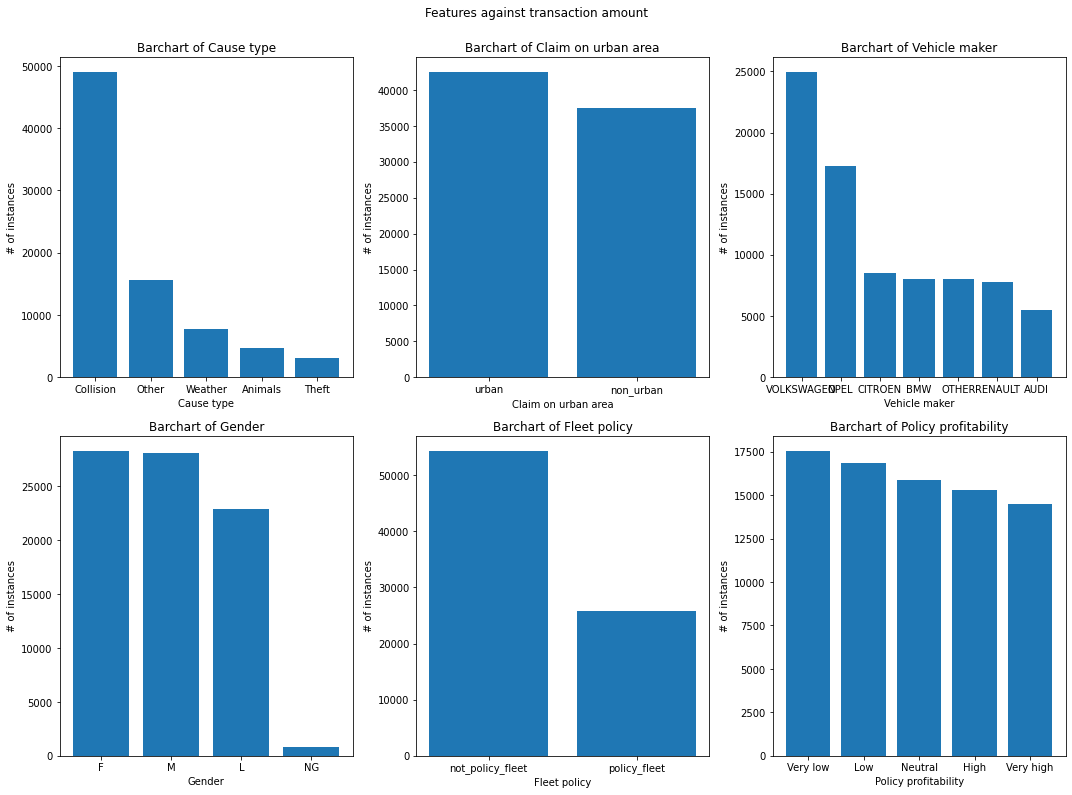

<Figure size 432x288 with 0 Axes>

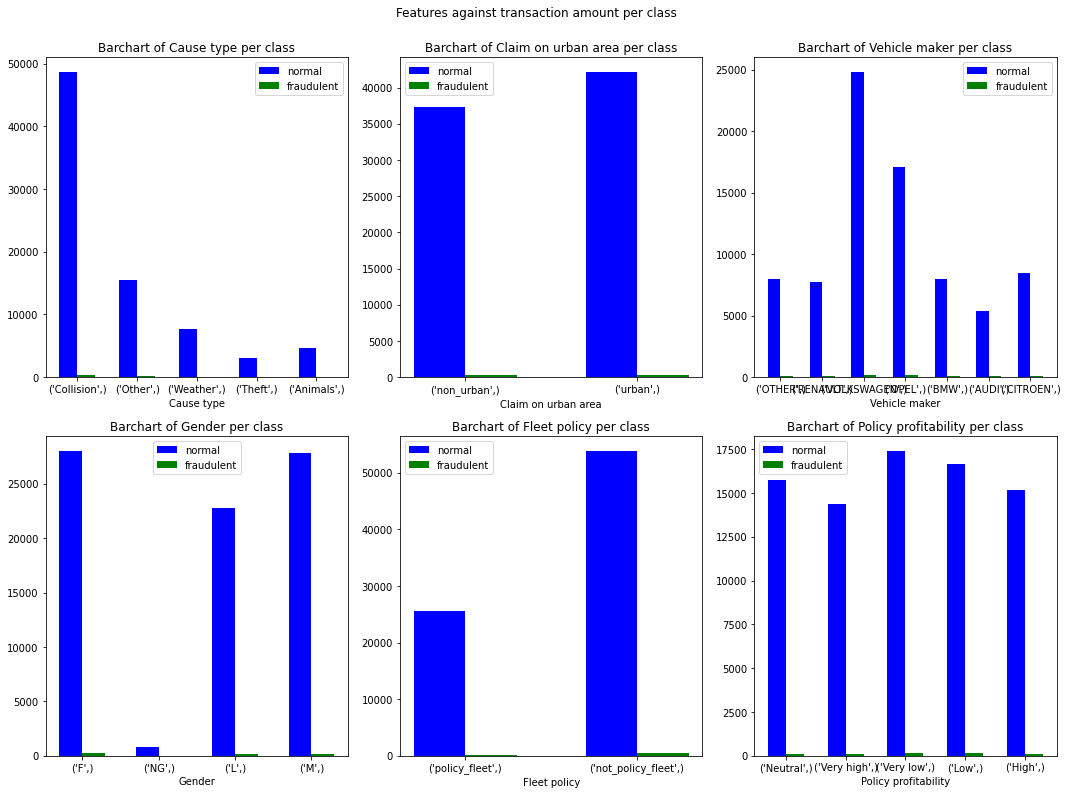

<Figure size 432x288 with 0 Axes>

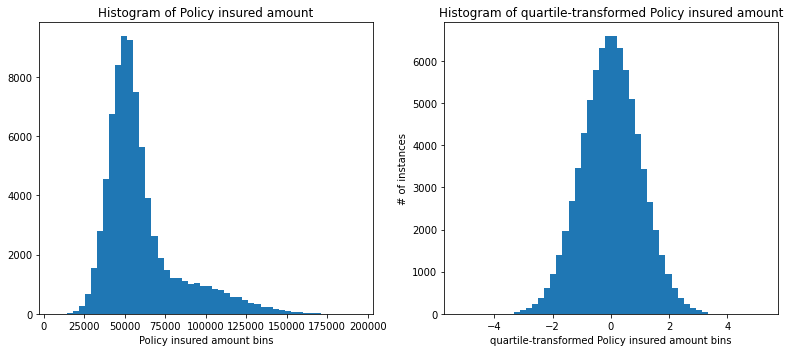

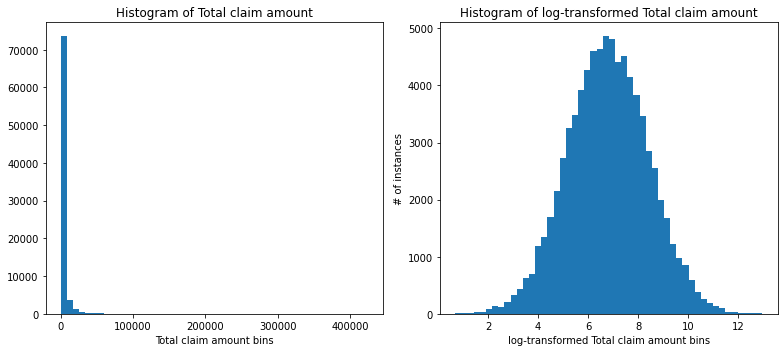

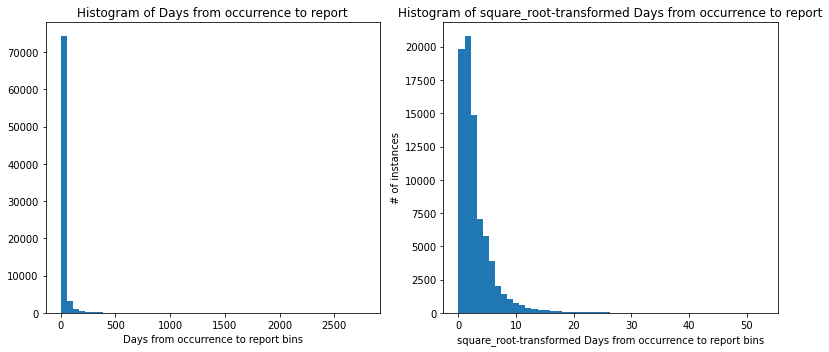

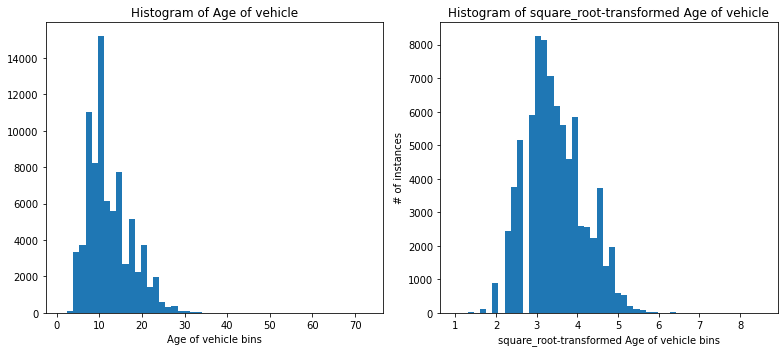

In [11]:
combined_df.replace({
        'policy_fleet_flag': {0: 'not_policy_fleet', 1: 'policy_fleet'},
        'claim_location_urban_area': {0: 'non_urban', 1: 'urban'}},
        inplace=True)
combined_df['object_age'] = datetime.now().year - combined_df['object_year_construction']
do_categorical_visualizations(combined_df, export=True)
do_categorical_visualizations_per_class(combined_df, export=True)
do_numerical_visualizations(combined_df, export=True)

## Data preparation for training
In this step the data is split into training and validation sets. The features of each set are then preprocessed or transformed (depending on the needs of each feature) and encoded appropriately. This is done in separate steps to avoid leaking information from validation to train through the various transformations.

Another important part of this step is that the different transformers and encoders are saved (using pickle) since they will be necessary for consistent data prepartion on the inference stage.

For encoding, on the continuous values, nothing more is used. An alternative would be to discretize the values in ranges and test the impact on the performance of a predictive model. For categorical features, one-hot-encoding is used. In some of these cases (_policy_profitability_) a case could be made for ordinal encoding as well, since there is an inherent order/structure in the feature values.

In [12]:
# preparing for training: feature preprocessing, transformation and encoding + data split
features = combined_df.drop(['fraud'], axis=1)
labels = combined_df['fraud']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=SEED,
                                                    stratify=labels)
X_train = __prepare_dataset(X_train)
X_test = __prepare_dataset(X_test)

## Model training
For a predictive model, a simple Logistic Regression is used. It will provide us with initial results and useful insights to either fine-tune this approach or adopt a different one. To have more reliable insights, SKLearn's _LogisticRegressionCV_ is used, which include not a single trained model for hyperparameter optimization but a cross validation over the data.

The first thing we need to keep in mind is the significant class imbalance of the problem. To make sure our predictive model does not only predict the dominant class, we employ a few techniques. First of all, our performance metric is F1 score (and specifically the weighted version available in Python's SKLearn). This metric takes into account both precision and recall, instead of just absolute accuracy. Also the balanced class weight is used on the Logistic Regressor for the same reason. During the data split, we make sure that both classes are represented by stratifying the split on the class labels.

In order to present results, a single number would not be intuitive or insightful enough, therefore a confusion matrix is used, which allows us to see not only the true positives and negatives but also the false ones and therefore determine the possible mistake tendencies of the predictive model. This will allow provide insights on how the model should be improved, also based on the client's use case (are FP or FN worse for their process? Here FN are considered worse).

To further evaluate our model, we investigate the coefficients of the features, which can serve as a rudimentary contribution indicator of each feature.

[>] Best parameters chosen from CV: [21.5443469]
[>] Train score: 0.818
[>] Test score: 0.818
[>] Feature coefficients:
Feature: policy_insured_amount, Score: 0.37344
Feature: claim_reported_days, Score: 0.10727
Feature: claim_amount_claimed_total, Score: 0.00802
Feature: object_age, Score: 0.04336
Feature: Animals, Score: -0.02165
Feature: Collision, Score: -0.03739
Feature: Other, Score: -0.06096
Feature: Theft, Score: 0.12373
Feature: Weather, Score: 0.00277
Feature: non_urban, Score: -0.02165
Feature: urban, Score: -0.03739
Feature: AUDI, Score: -0.02165
Feature: BMW, Score: -0.03739
Feature: CITROEN, Score: -0.06096
Feature: OPEL, Score: 0.12373
Feature: OTHER, Score: 0.00277
Feature: RENAULT, Score: -0.05430
Feature: VOLKSWAGEN, Score: 0.06080
Feature: F, Score: -0.02165
Feature: L, Score: -0.03739
Feature: M, Score: -0.06096
Feature: NG, Score: 0.12373
Feature: not_policy_fleet, Score: -0.02165
Feature: policy_fleet, Score: -0.03739
[>] Confusion matrix on validation sub-set


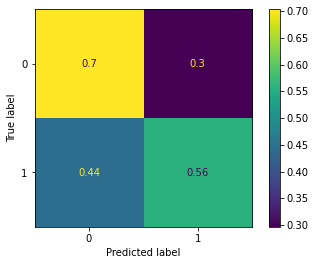

In [13]:
model = LogisticRegressionCV(
    Cs=10,
    cv=3,
    max_iter=300,
    penalty='l2',
    scoring=make_scorer(f1_score, average='weighted'),
    solver='lbfgs',
    class_weight='balanced',
    random_state=SEED
)
model.fit(X_train, y_train)
print(f'[>] Best parameters chosen from CV: {model.C_}')
print(f'[>] Train score: {model.score(X_train, y_train):.3f}')
print(f'[>] Test score: {model.score(X_test, y_test):.3f}')
print('[>] Feature coefficients:')
importance = model.coef_[0]
for i,v in zip(model.feature_names_in_, importance):
    print(f'Feature: {i}, Score: {v:.5f}')
print('[>] Confusion matrix on validation sub-set')
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
with open(Path('./logit_model_pkl'), 'wb') as f:
    pickle.dump(model, f)

In [14]:
test_data = __read_data(Path(TESTING_PATH))
test_data = __feature_selection(test_data)
test_data = __handle_missing_values(test_data, inference=True)
test_labels = test_data['sys_fraud']
test_data.drop(['sys_fraud'], axis=1)
test_data = __inference_prepare_data(test_data)

[>] Read data/FRISS_ClaimHistory_test.csv:
 - Shape: (20000, 21)
[>] Dropping the following columns for lack of infromative value: ['sys_sector', 'sys_label', 'sys_process', 'sys_product', 'sys_dataspecification_version', 'sys_currency_code', 'ph_firstname', 'ph_name', 'sys_claimid']
[>] Dropping initial id column, only need one identifier to trace instances


In [15]:
print(test_data.columns)
print(X_train.columns)

Index(['policy_insured_amount', 'claim_reported_days',
       'claim_amount_claimed_total', 'object_age', 'Animals', 'Collision',
       'Other', 'Theft', 'Weather', 'non_urban', 'urban', 'AUDI', 'BMW',
       'CITROEN', 'OPEL', 'OTHER', 'RENAULT', 'VOLKSWAGEN', 'F', 'L', 'M',
       'NG', 'not_policy_fleet', 'policy_fleet'],
      dtype='object')
Index(['policy_insured_amount', 'claim_reported_days',
       'claim_amount_claimed_total', 'object_age', 'Animals', 'Collision',
       'Other', 'Theft', 'Weather', 'non_urban', 'urban', 'AUDI', 'BMW',
       'CITROEN', 'OPEL', 'OTHER', 'RENAULT', 'VOLKSWAGEN', 'F', 'L', 'M',
       'NG', 'not_policy_fleet', 'policy_fleet'],
      dtype='object')


[>] Score on test set: 0.8166443955606352
[>] Confusion matrix on test set:


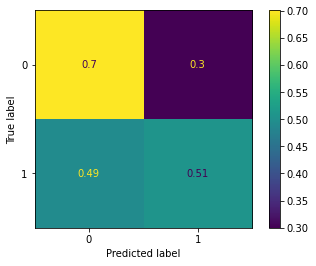

In [16]:
print(f'[>] Score on test set: {model.score(test_data, test_labels)}')
print('[>] Confusion matrix on test set:')
test_preds = model.predict(test_data)
cm = confusion_matrix(test_labels, test_preds, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

## Conclusion
The overall performance of the model is still sub-optimal. 70% of true negatives are correctly identified and 56% of true positives. Although the minority class is identified and predicted, the cost in false positives is still very high. Depending on the process of the client, FP might not be as detrimental as FN, where a fraud case escapes detection. The main problem with this model's performance is the fact that we classify correctly barely over 50% of the fraudulent cases and this should be the first issue to be addressed during next steps. Performance on the completely kept out test set (from the test csv) is slighlty lower than in training.

Our rudimentary feature importance shows that several of the features contribute to a significant extent. There is a case to be made though for more extensive feature importance investigation, with examples being _claim_amount_claimed_total_ and _Weather_ from the _claim_causetype_ feature.

## Next steps
Based on this POC approach on the fraud detection problem, the following points are worth testing and investigating further:
1. Feature selection, engineering and preprocessing/encoding: 
    * features could be removed based on their importance. ANOVA and other methods could be employed towards this direction.
    * New features could also be engineered to contribute to the task. For example instead of using the vehicle brand, a grouping into luxury, family, sport etc. cars could be made based on that feature.
    * On the preprocessing and encoding step, features like the _claim_reported_days_ could be employed differently and be discretized into generic time lapses (days, weeks, months from occurrence to report) or could be separated into normal/delayed/late based on the overall statistics of the feature value. Similar approaches could be taken for the other continuous features. On another approach, we are aware that some of the feature trasnformations were not 100% successful, thus providing a definite improvement point.
2. Model selection:
    * Logistic regression could be used in a more elaborate way, by specifically preparing the dataset for this method and follow it up by more elaborate optimization of its parameters.
    * More elaborate models could be used. A suggested path would be SMVs to simple neural networs (e.g. MLPs) to investigate if such algorithms are better at representing the data's underlying strucure.
3. Problem understaning: there were a few points during the POC that questions for the client arose, specific to the data, the problem or the process. Clarifying these points could also provide valuable insights in developing a high-performing, reliable solution.